In [1]:
import numpy as np
import pandas as pd 
import pickle
import os
import sklearn
import re
import pickle
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
%matplotlib inline

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict1 = pickle.load(fo, encoding='bytes')
    return dict1

Unpickling batches of training data and separating pixel values and labels into different dataframes.

In [3]:
pd_tr = pd.DataFrame()
tr_y = pd.DataFrame()
for i in range(1,6):
    data = unpickle('data/data_batch_' + str(i))
    pd_tr = pd_tr.append(pd.DataFrame(data[b'data']))
    tr_y = tr_y.append(pd.DataFrame(data[b'labels']))
pd_tr['labels'] = tr_y
pd_tr.head(5)

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,labels
0,59,43,50,68,98,119,139,145,149,149,...,58,65,59,46,57,104,140,84,72,6
1,154,126,105,102,125,155,172,180,142,111,...,42,67,101,122,133,136,139,142,144,9
2,255,253,253,253,253,253,253,253,253,253,...,83,80,69,66,72,79,83,83,84,9
3,28,37,38,42,44,40,40,24,32,43,...,39,59,42,44,48,38,28,37,46,4
4,170,168,177,183,181,177,181,184,189,189,...,88,85,82,83,79,78,82,78,80,1


In [4]:
pd_tr = shuffle(pd_tr)
pd_tr.head(5)

,0,1,2,3,4,5,6,7,8,9,...,3063,3064,3065,3066,3067,3068,3069,3070,3071,labels
4989,139,146,150,155,152,161,165,169,161,162,...,200,205,200,196,184,177,196,196,187,6
1755,229,225,224,223,220,221,228,231,228,223,...,98,100,99,99,99,97,104,106,102,8
6134,133,133,134,134,135,136,136,137,137,137,...,97,97,97,98,98,98,97,97,96,8
8081,135,150,158,137,122,115,102,79,75,66,...,60,60,61,68,87,101,109,110,115,8
1747,81,112,126,134,122,104,110,119,124,126,...,96,98,97,98,105,105,101,100,101,1


In [5]:
tr_x = np.asarray(pd_tr.iloc[:, :3072]).astype(np.float64)
ts_x = np.asarray(unpickle('data/test_batch')[b'data']).astype(np.float64)
ytr = np.asarray(pd_tr['labels'])
yts = np.asarray(unpickle('data/test_batch')[b'labels'])
tr_x.shape

(50000, 3072)

The above number can be calculated as 32(breadth) x 32(width) x 3(color channels) x 10000 (images per batch) x 5 (number of training batches)

### Exploring the dataset

Taking the label names from batches.meta and checking the categories of the images in the dataset.

In [6]:
labels = unpickle('data/batches.meta')[b'label_names']
labels

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

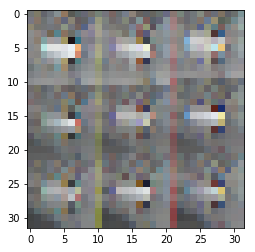

In [7]:
plt.imshow(tr_x[120].reshape(32,32,3))

If you look carefully, you can see that it looks like an animal, probably a horse and that it is repeated around 9 times. This is because the reshaping was not done depth-wise. So we need to stack the array by separating the red, green and blue arrays and stacking them depth-wise. The below function takes a flattened array from the dataset and plots the RGB image.

In [9]:
def plot_CIFAR(ind):
    arr = tr_x[ind]
    R = arr[0:1024].reshape(32,32)/255.0
    G = arr[1024:2048].reshape(32,32)/255.0
    B = arr[2048:].reshape(32,32)/255.0
    
    img = np.dstack((R,G,B))
    title = re.sub('[!@#$b]', '', str(labels[ytr[ind]]))
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(111)
    ax.imshow(img,interpolation='bicubic')
    ax.set_title('Category = '+ title,fontsize =15)

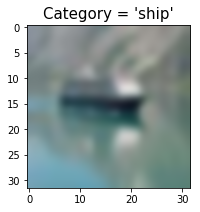

In [10]:
plot_CIFAR(120)

This is the most sharpened the CIFAR-10 images get. This is because the original image is 32px X 32px, which is a lot smaller than the above image. 

### Normalizing 

Normalizing features (image pixels here) is an important pre-processing step in the learning process as it standardizes the features, implicitly letting the weights be considered equally.

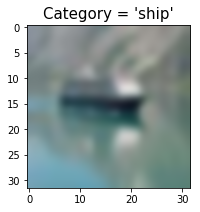

In [53]:
mean_tr = tr_x.mean(axis=0)
mean_ts = tr_x.mean(axis=0)
std_tr  = tr_x.std(axis=0)
std_ts  = ts_x.std(axis=0)

xtr = (tr_x-mean_tr.T)
xts = (ts_x-mean_ts.T)
# xtr = (tr_x-mean_tr.T)/(std_tr.T)
# xts = (ts_x-mean_ts.T)/(std_ts.T)
plot_CIFAR(120)

In [ ]:
95.69759115, 154.25260417,61.67936198

### Simple 3-layer deep neural network

In [54]:
n_samp = xtr.shape[0]
n_feat = xtr.shape[1]

n_nodes_hl1 = 600
n_nodes_hl2 = 100
n_nodes_hl3 = 100

n_classes = 10
batch_size = 200 # the number of training examples in one forward/backward pass

x = tf.placeholder('float' ,[None,xtr.shape[1]])
y = tf.placeholder('float',[None,n_classes])

label_binarizer = LabelBinarizer()
label_binarizer.fit(range(n_classes))

yohtr = label_binarizer.transform(ytr)
yohts = label_binarizer.transform(yts)

In [55]:
yohtr.shape

(50000, 10)

In [56]:
def neural_network_model(data):

    # initializing weights and biases for the hidden layers and the output layer
    hidden_l1 = {'weights': tf.Variable(tf.random_normal([n_feat,n_nodes_hl1])), 
                 'biases':tf.Variable(tf.random_normal([n_nodes_hl1]))}

    hidden_l2 = {'weights': tf.Variable(tf.random_normal([n_nodes_hl1,n_nodes_hl2])), 
                 'biases':tf.Variable(tf.random_normal([n_nodes_hl2]))}

    hidden_l3 = {'weights': tf.Variable(tf.random_normal([n_nodes_hl2,n_nodes_hl3])), 
                 'biases':tf.Variable(tf.random_normal([n_nodes_hl3]))}

    output_l = {'weights': tf.Variable(tf.random_normal([n_nodes_hl3,n_classes])), 
                 'biases':tf.Variable(tf.random_normal([n_classes]))}

    # computing the ouput of each layer and applying a non-linearity at the end of each layer computation
    l1 = tf.add(tf.matmul(data, hidden_l1['weights']), hidden_l1['biases'])
    l1 = tf.nn.relu(l1)

    l2 = tf.add(tf.matmul(l1, hidden_l2['weights']), hidden_l2['biases'])
    l2 = tf.nn.relu(l2)

    l3 = tf.add(tf.matmul(l2, hidden_l3['weights']), hidden_l3['biases'])
    l3 = tf.nn.relu(l3)

    output = tf.add(tf.matmul(l3, output_l['weights']), output_l['biases'])

    return output

In [57]:
def train_neural_network(x):
    prediction = neural_network_model(x)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))

    # learning rate = 0.001
    optimizer = tf.train.AdamOptimizer().minimize(cost)

    # one epoch = one cycle of feed-forward and backprop
    n_epochs = 10
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch in range(n_epochs):
            epoch_loss = 0
            for index, offset in enumerate(range(0,n_samp, batch_size)):
                x_epoch, y_epoch = np.array(tr_x[offset:offset + batch_size,:]), np.array(yohtr[offset:offset + batch_size])
                _, c = sess.run([optimizer, cost], feed_dict ={x:x_epoch, y:y_epoch}) 
                epoch_loss +=c
            print ('Epoch', epoch, 'completed out of', n_epochs, 'loss:', epoch_loss)

        correct = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
        accuracy  = tf.reduce_mean(tf.cast(correct, 'float'))
        print('Accuracy:', accuracy.eval({x:ts_x, y:yohts}))
        
#         prediction_fin=tf.argmax(prediction,1)
#         test_pred = (np.asarray(sess.run([prediction_fin],feed_dict={x:xts})).T)
                              
#         pred_pd = pd.read_csv(csv_test, index_col = 0)
#         pred_pd['label'] =test_pred
#         pred_pd.to_csv(csv_predicted)
#         print('Test:',test_pred)
        
train_neural_network(x)

Epoch 0 completed out of 10 loss: 252294088.219
Epoch 1 completed out of 10 loss: 75563735.0469
Epoch 2 completed out of 10 loss: 51514568.3594
Epoch 3 completed out of 10 loss: 38251913.8906
Epoch 4 completed out of 10 loss: 29022473.0156
Epoch 5 completed out of 10 loss: 22547565.1797
Epoch 6 completed out of 10 loss: 18144337.9844
Epoch 7 completed out of 10 loss: 14741401.7891
Epoch 8 completed out of 10 loss: 12223621.2813
Epoch 9 completed out of 10 loss: 10222211.3008
Accuracy: 0.2557
